In [ ]:
# Synthetic Sentiment Data Generation Notebook

# Step 1: Read Stratified Sampled Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch
import random
from tqdm import tqdm
from transformers import pipeline

# Assuming the dataset is named 'stratified_sampled_validated.csv'
df = pd.read_csv("/content/drive/MyDrive/Mini Project/Generated/sampled.csv")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Step 2: Display Dataset
print("Sample Data:")
print(df.head())




Sample Data:
                                                text  sentiment_label  \
0  india joins the elite club congratulations all...              1.0   
1  this pure bravery only firing bullets and ches...              1.0   
2  you are true you have guts then the video wher...              1.0   
3  when modi was destroying economy with demoneti...             -1.0   
4                                        excellent                1.0   

   emotion_label  hate_speech_label     source_dataset fine_grained_label  \
0            1.0                0.0  sentiment_dataset             joyful   
1            0.0                0.0  sentiment_dataset         melancholy   
2            1.0                0.0  sentiment_dataset             joyful   
3            1.0                0.0  sentiment_dataset             joyful   
4            1.0                0.0  sentiment_dataset             joyful   

  sentiment_label_text predicted_sentiment_label  \
0             Positive           


Label Distribution - Overall Sentiment:
sentiment_str
negative    11423
positive    10086
neutral       135
Name: count, dtype: int64

Label Distribution - Fine-Grained Sentiment:
predicted_fine_grained
surprise    10761
joy          4010
sadness      1495
fear         1430
hate         1402
anger        1139
love          879
neutral       528
Name: count, dtype: int64

Null Values:
text                                     0
sentiment_label                          0
emotion_label                            0
hate_speech_label                        0
source_dataset                           0
fine_grained_label                       0
sentiment_label_text                     0
predicted_sentiment_label                0
bert_predicted_sentiment_label           0
predicted_sentiment_label_numeric        0
final_sentiment                          0
final_sentiment_label                    0
validation_flags                     11554
final_validation_flags               13971
fine_grain

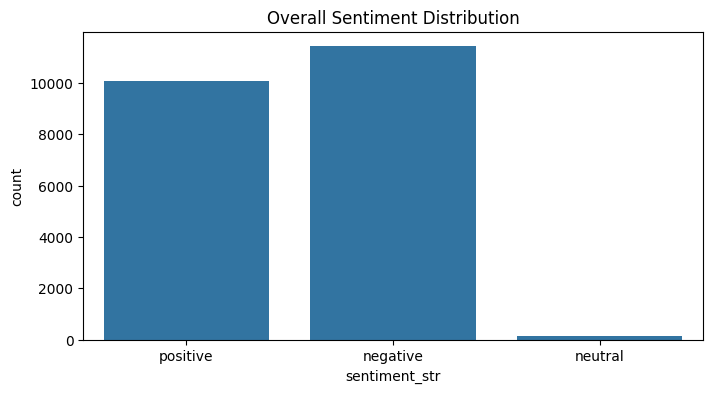

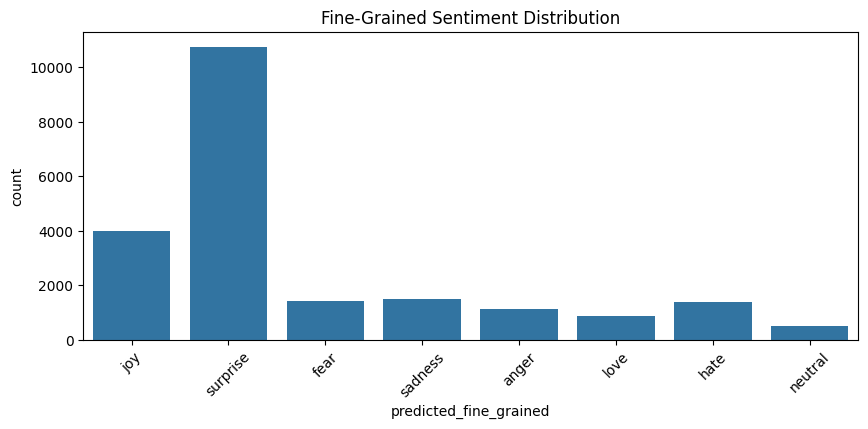

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [ ]:
# Step 3: Check Label Distribution
print("\nLabel Distribution - Overall Sentiment:")
print(df["sentiment_str"].value_counts())

print("\nLabel Distribution - Fine-Grained Sentiment:")
print(df["predicted_fine_grained"].value_counts())

# Step 4: Check Null Values
print("\nNull Values:")
print(df.isnull().sum())

# Step 5: Basic EDA
plt.figure(figsize=(8,4))
sns.countplot(data=df, x="sentiment_str")
plt.title("Overall Sentiment Distribution")
plt.show()

plt.figure(figsize=(10,4))
sns.countplot(data=df, x="predicted_fine_grained")
plt.title("Fine-Grained Sentiment Distribution")
plt.xticks(rotation=45)
plt.show()

# Step 6: Synthetic Data Generation with FLAN-T5
flan_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base")
flan_tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

device = "cuda" if torch.cuda.is_available() else "cpu"
flan_model.to(device)



In [ ]:
def generate_synthetic_text(prompt, max_length=256):
    inputs = flan_tokenizer(prompt, return_tensors="pt").to(device)
    outputs = flan_model.generate(**inputs, max_length=max_length)
    return flan_tokenizer.decode(outputs[0], skip_special_tokens=True)

# Define hierarchical mapping
sentiment_mapping = {
    "neutral": ["neutral"],
    "positive": ["joy", "love", "surprise"],
    "negative": ["sadness", "anger", "fear"]
}

# Load FLAN-T5 model for text generation with pipeline
generator = pipeline("text2text-generation", model="google/flan-t5-large", device=0 if torch.cuda.is_available() else -1)

synthetic_data = []

for overall in sentiment_mapping:
    fine_options = sentiment_mapping[overall]
    for _ in tqdm(range(700), desc=f"Generating for '{overall}'", ncols=100):
        fine = random.choice(fine_options)
        prompt = f"Generate a social media post/tweet that expresses {fine} emotion with an overall {overall} sentiment."
        response = generator(prompt,
                             max_length=140,
                             min_length=100,
                             do_sample=True,
                             top_k=50)[0]['generated_text']
        synthetic_data.append({
            "text": response,
            "overall_sentiment": overall,
            "fine_grained_sentiment": fine
        })

synthetic_df = pd.DataFrame(synthetic_data)

# # Step 7: Validate Synthetic Data Using XLNet
# from transformers import XLNetTokenizer, XLNetForSequenceClassification, Trainer, TrainingArguments
# from datasets import Dataset
# import numpy as np
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# le_overall = LabelEncoder()
# synthetic_df["overall_label"] = le_overall.fit_transform(synthetic_df["overall_sentiment"])

# tokenizer = XLNetTokenizer.from_pretrained("xlnet-base-cased")
# def tokenize(batch):
#     return tokenizer(batch["text"], padding=True, truncation=True)

# xlnet_dataset = Dataset.from_pandas(synthetic_df[["text", "overall_label"]].rename(columns={"overall_label": "labels"}))
# xlnet_dataset = xlnet_dataset.map(tokenize, batched=True)
# xlnet_dataset = xlnet_dataset.train_test_split(test_size=0.2)

# model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=len(le_overall.classes_))

# training_args = TrainingArguments(
#     output_dir="./xlnet_validation",
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     num_train_epochs=1,
#     evaluation_strategy="epoch",
#     logging_steps=10,
#     report_to="none"
# )

# def compute_metrics(pred):
#     labels = pred.label_ids
#     preds = np.argmax(pred.predictions, axis=1)
#     acc = accuracy_score(labels, preds)
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
#     return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=xlnet_dataset["train"],
#     eval_dataset=xlnet_dataset["test"],
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics
# )

# trainer.train()
# eval_results = trainer.evaluate()

# print("\nXLNet Validation Results on Synthetic Data:")
# print(eval_results)

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cpu
Generating for 'neutral':  23%|███████▍                         | 158/700 [59:33<3:48:41, 25.32s/it]

In [ ]:
import random
import pandas as pd
from tqdm import tqdm
import torch
from transformers import pipeline

# Define mapping
neutral_mapping = {
    "neutral": ["neutral"]
}

# FLAN-T5 generation pipeline
generator = pipeline("text2text-generation", model="google/flan-t5-large", device=0 if torch.cuda.is_available() else -1)

neutral_data = []

for overall in neutral_mapping:
    fine_options = neutral_mapping[overall]
    for _ in tqdm(range(700), desc=f"Generating for '{overall}'", ncols=100):
        fine = random.choice(fine_options)
        prompt = f"Generate a social media post/tweet that expresses {fine} emotion with an overall {overall} sentiment."
        response = generator(prompt,
                             max_length=140,
                             min_length=100,
                             do_sample=True,
                             top_k=50)[0]['generated_text']
        neutral_data.append({
            "text": response,
            "overall_sentiment": overall,
            "fine_grained_sentiment": fine
        })

neutral_df = pd.DataFrame(neutral_data)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

Device set to use cuda:0
Generating for 'neutral': 100%|███████████████████████████████████| 700/700 [48:32<00:00,  4.16s/it]


In [ ]:
neutral_df.to_csv("/content/drive/MyDrive/Mini Project/Generated/neutral_data.csv", index=False)


In [ ]:
positive_mapping = {
    "positive": ["joy", "love", "surprise"]
}

positive_data = []

for overall in positive_mapping:
    fine_options = positive_mapping[overall]
    for _ in tqdm(range(700), desc=f"Generating for '{overall}'", ncols=100):
        fine = random.choice(fine_options)
        prompt = f"Generate a social media post/tweet that expresses {fine} emotion with an overall {overall} sentiment."
        response = generator(prompt,
                             max_length=140,
                             min_length=100,
                             do_sample=True,
                             top_k=50)[0]['generated_text']
        positive_data.append({
            "text": response,
            "overall_sentiment": overall,
            "fine_grained_sentiment": fine
        })

positive_df = pd.DataFrame(positive_data)


In [ ]:
negative_mapping = {
    "negative": ["sadness", "anger", "fear"]
}

negative_data = []

for overall in negative_mapping:
    fine_options = negative_mapping[overall]
    for _ in tqdm(range(700), desc=f"Generating for '{overall}'", ncols=100):
        fine = random.choice(fine_options)
        prompt = f"Generate a social media post/tweet that expresses {fine} emotion with an overall {overall} sentiment."
        response = generator(prompt,
                             max_length=140,
                             min_length=100,
                             do_sample=True,
                             top_k=50)[0]['generated_text']
        negative_data.append({
            "text": response,
            "overall_sentiment": overall,
            "fine_grained_sentiment": fine
        })

negative_df = pd.DataFrame(negative_data)


##evaluation

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer
)
from datasets import Dataset
import torch


def train_and_predict_all_models(
    df,
    target_col="label",
    transformers_models=[
        "distilbert-base-uncased",
        "bert-base-uncased",
        "roberta-base",
        "cardiffnlp/twitter-roberta-base-sentiment",
        "xlm-roberta-base"
    ],
    test_size=0.2,
    max_length=128,
    use_cuda=torch.cuda.is_available()
):
    def run_ml_models(df):
        print(f"\n----- Traditional ML Models -----\n")
        X = df["text"]
        y = df[target_col]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)

        models = {
            "Logistic Regression": LogisticRegression(max_iter=1000),
            "Naive Bayes": MultinomialNB(),
            "SVM": SVC(),
            "Random Forest": RandomForestClassifier()
        }

        for name, model in models.items():
            pipe = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', model)
            ])
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)
            print(f"\nModel: {name}")
            print(classification_report(y_test, y_pred))

    def run_transformer_models(df):
        print(f"\n----- Transformer Models -----\n")

        for model_name in transformers_models:
            print(f"\nTransformer: {model_name}\n")
            tokenizer = AutoTokenizer.from_pretrained(model_name)

            def tokenize_function(examples):
                return tokenizer(
                    examples['text'],
                    padding="max_length",
                    truncation=True,
                    max_length=max_length
                )

            hf_dataset = Dataset.from_pandas(
                df[["text", target_col]].rename(columns={target_col: "label"})
            )
            hf_dataset = hf_dataset.class_encode_column("label")
            num_labels = hf_dataset.features['label'].num_classes

            tokenized_dataset = hf_dataset.map(tokenize_function, batched=True)
            tokenized_dataset = tokenized_dataset.train_test_split(test_size=test_size)
            tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

            model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

            training_args = TrainingArguments(
                output_dir=f"./results/{model_name.replace('/', '_')}",
                learning_rate=2e-5,
                per_device_train_batch_size=8,
                per_device_eval_batch_size=8,
                num_train_epochs=10,
                weight_decay=0.01,
                save_strategy="no",
                logging_dir="./logs",
                disable_tqdm=True,
            )
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=tokenized_dataset['train'],
                eval_dataset=tokenized_dataset['test']
            )

            trainer.train()
            preds = trainer.predict(tokenized_dataset['test'])
            y_pred = preds.predictions.argmax(axis=-1)
            y_true = tokenized_dataset['test']['label']

            print(classification_report(y_true, y_pred))

    # Run models
    run_ml_models(df.copy())
    run_transformer_models(df.copy())


In [ ]:
synthetic_df=pd.read_csv("/content/drive/MyDrive/Mini Project/Generated/synthetic_dataset_from_stratified_sampled.csv")

In [ ]:
train_and_predict_all_models(synthetic_df,target_col="overall_sentiment")



----- Traditional ML Models -----


Model: Logistic Regression
              precision    recall  f1-score   support

    negative       0.56      0.71      0.63       140
     neutral       0.38      0.34      0.36       140
    positive       0.60      0.50      0.55       140

    accuracy                           0.52       420
   macro avg       0.52      0.52      0.51       420
weighted avg       0.52      0.52      0.51       420


Model: Naive Bayes
              precision    recall  f1-score   support

    negative       0.51      0.88      0.64       140
     neutral       0.44      0.30      0.36       140
    positive       0.66      0.39      0.49       140

    accuracy                           0.52       420
   macro avg       0.54      0.52      0.50       420
weighted avg       0.54      0.52      0.50       420


Model: SVM
              precision    recall  f1-score   support

    negative       0.56      0.71      0.63       140
     neutral       0.40      0.36

Casting to class labels:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: avantithale0922 (avantithale0922-sardar-vallabhbhai-national-institute-of) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'loss': 0.7956, 'grad_norm': 15.0437650680542, 'learning_rate': 1.5247619047619049e-05, 'epoch': 2.380952380952381}
{'loss': 0.3649, 'grad_norm': 16.9278507232666, 'learning_rate': 1.0485714285714286e-05, 'epoch': 4.761904761904762}
{'loss': 0.1244, 'grad_norm': 0.35191428661346436, 'learning_rate': 5.723809523809525e-06, 'epoch': 7.142857142857143}
{'loss': 0.0465, 'grad_norm': 0.09176500141620636, 'learning_rate': 9.61904761904762e-07, 'epoch': 9.523809523809524}
{'train_runtime': 257.1996, 'train_samples_per_second': 65.319, 'train_steps_per_second': 8.165, 'train_loss': 0.31923922016507106, 'epoch': 10.0}
              precision    recall  f1-score   support

           0       0.75      0.65      0.69       140
           1       0.41      0.55      0.47       132
           2       0.70      0.59      0.64       148

    accuracy                           0.60       420
   macro avg       0.62      0.59      0.60       420
weighted avg       0.63      0.60      0.60       420




tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Casting to class labels:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.7937, 'grad_norm': 10.025525093078613, 'learning_rate': 1.5247619047619049e-05, 'epoch': 2.380952380952381}
{'loss': 0.2921, 'grad_norm': 20.34478187561035, 'learning_rate': 1.0485714285714286e-05, 'epoch': 4.761904761904762}
{'loss': 0.0702, 'grad_norm': 0.03373971953988075, 'learning_rate': 5.723809523809525e-06, 'epoch': 7.142857142857143}
{'loss': 0.0201, 'grad_norm': 0.02008245326578617, 'learning_rate': 9.61904761904762e-07, 'epoch': 9.523809523809524}
{'train_runtime': 423.4427, 'train_samples_per_second': 39.675, 'train_steps_per_second': 4.959, 'train_loss': 0.2806657371066865, 'epoch': 10.0}
              precision    recall  f1-score   support

           0       0.80      0.69      0.74       152
           1       0.46      0.58      0.51       131
           2       0.67      0.61      0.64       137

    accuracy                           0.63       420
   macro avg       0.64      0.63      0.63       420
weighted avg       0.65      0.63      0.64       420


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Casting to class labels:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.7911, 'grad_norm': 21.433074951171875, 'learning_rate': 1.5247619047619049e-05, 'epoch': 2.380952380952381}
{'loss': 0.4321, 'grad_norm': 11.36286449432373, 'learning_rate': 1.0485714285714286e-05, 'epoch': 4.761904761904762}
{'loss': 0.1959, 'grad_norm': 0.8404903411865234, 'learning_rate': 5.723809523809525e-06, 'epoch': 7.142857142857143}
{'loss': 0.0668, 'grad_norm': 3.0284016132354736, 'learning_rate': 9.61904761904762e-07, 'epoch': 9.523809523809524}
{'train_runtime': 434.1313, 'train_samples_per_second': 38.698, 'train_steps_per_second': 4.837, 'train_loss': 0.3569768962405977, 'epoch': 10.0}
              precision    recall  f1-score   support

           0       0.80      0.64      0.71       152
           1       0.43      0.58      0.49       131
           2       0.67      0.60      0.63       137

    accuracy                           0.61       420
   macro avg       0.63      0.61      0.61       420
weighted avg       0.64      0.61      0.62       420




config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Casting to class labels:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

{'loss': 0.7324, 'grad_norm': 23.9942626953125, 'learning_rate': 1.5247619047619049e-05, 'epoch': 2.380952380952381}
{'loss': 0.3327, 'grad_norm': 0.5531108379364014, 'learning_rate': 1.0485714285714286e-05, 'epoch': 4.761904761904762}
{'loss': 0.1194, 'grad_norm': 0.07743724435567856, 'learning_rate': 5.723809523809525e-06, 'epoch': 7.142857142857143}
{'loss': 0.037, 'grad_norm': 0.01831653155386448, 'learning_rate': 9.61904761904762e-07, 'epoch': 9.523809523809524}
{'train_runtime': 434.5402, 'train_samples_per_second': 38.662, 'train_steps_per_second': 4.833, 'train_loss': 0.2921518082845779, 'epoch': 10.0}
              precision    recall  f1-score   support

           0       0.77      0.63      0.70       152
           1       0.42      0.49      0.45       131
           2       0.62      0.66      0.64       137

    accuracy                           0.60       420
   macro avg       0.61      0.59      0.60       420
weighted avg       0.62      0.60      0.60       420




tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Casting to class labels:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.8902, 'grad_norm': 10.005780220031738, 'learning_rate': 1.5247619047619049e-05, 'epoch': 2.380952380952381}
{'loss': 0.591, 'grad_norm': 38.665950775146484, 'learning_rate': 1.0485714285714286e-05, 'epoch': 4.761904761904762}
{'loss': 0.3162, 'grad_norm': 24.91164779663086, 'learning_rate': 5.723809523809525e-06, 'epoch': 7.142857142857143}
{'loss': 0.1611, 'grad_norm': 0.11944792419672012, 'learning_rate': 9.61904761904762e-07, 'epoch': 9.523809523809524}
{'train_runtime': 575.2877, 'train_samples_per_second': 29.203, 'train_steps_per_second': 3.65, 'train_loss': 0.47223916235424224, 'epoch': 10.0}
              precision    recall  f1-score   support

           0       0.73      0.61      0.66       152
           1       0.40      0.56      0.47       131
           2       0.65      0.53      0.58       137

    accuracy                           0.57       420
   macro avg       0.59      0.57      0.57       420
weighted avg       0.60      0.57      0.58       420



In [ ]:
train_and_predict_all_models(synthetic_df,target_col="fine_grained_sentiment")



----- Traditional ML Models -----


Model: Logistic Regression
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        35
        fear       0.00      0.00      0.00        35
        hate       0.67      0.06      0.11        35
         joy       0.29      0.04      0.07        47
        love       0.52      0.28      0.37        46
     neutral       0.36      0.92      0.51       140
     sadness       0.50      0.17      0.26        35
    surprise       0.00      0.00      0.00        47

    accuracy                           0.36       420
   macro avg       0.29      0.18      0.16       420
weighted avg       0.30      0.36      0.25       420


Model: Naive Bayes


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        35
        fear       0.00      0.00      0.00        35
        hate       0.00      0.00      0.00        35
         joy       0.00      0.00      0.00        47
        love       0.00      0.00      0.00        46
     neutral       0.33      1.00      0.50       140
     sadness       0.00      0.00      0.00        35
    surprise       0.00      0.00      0.00        47

    accuracy                           0.33       420
   macro avg       0.04      0.12      0.06       420
weighted avg       0.11      0.33      0.17       420


Model: SVM
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        35
        fear       0.00      0.00      0.00        35
        hate       0.00      0.00      0.00        35
         joy       0.00      0.00      0.00        47
        love       0.56      0.11      0.18        46
     neutral

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Model: Random Forest
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        35
        fear       0.00      0.00      0.00        35
        hate       1.00      0.03      0.06        35
         joy       0.40      0.04      0.08        47
        love       0.33      0.13      0.19        46
     neutral       0.34      0.94      0.50       140
     sadness       0.75      0.09      0.15        35
    surprise       0.00      0.00      0.00        47

    accuracy                           0.34       420
   macro avg       0.35      0.15      0.12       420
weighted avg       0.34      0.34      0.21       420


----- Transformer Models -----


Transformer: distilbert-base-uncased



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Casting to class labels:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 1.7249, 'grad_norm': 5.821859836578369, 'learning_rate': 1.5247619047619049e-05, 'epoch': 2.380952380952381}
{'loss': 1.2534, 'grad_norm': 13.390127182006836, 'learning_rate': 1.0485714285714286e-05, 'epoch': 4.761904761904762}
{'loss': 0.7645, 'grad_norm': 10.920404434204102, 'learning_rate': 5.723809523809525e-06, 'epoch': 7.142857142857143}
{'loss': 0.4611, 'grad_norm': 16.77252960205078, 'learning_rate': 9.61904761904762e-07, 'epoch': 9.523809523809524}
{'train_runtime': 214.283, 'train_samples_per_second': 78.401, 'train_steps_per_second': 9.8, 'train_loss': 1.0187240182785762, 'epoch': 10.0}
              precision    recall  f1-score   support

           0       0.17      0.10      0.12        42
           1       0.33      0.27      0.30        45
           2       0.46      0.32      0.38        37
           3       0.30      0.32      0.31        44
           4       0.41      0.29      0.34        49
           5       0.42      0.59      0.50       133
       

Casting to class labels:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 1.6091, 'grad_norm': 6.910473823547363, 'learning_rate': 1.5247619047619049e-05, 'epoch': 2.380952380952381}
{'loss': 0.8631, 'grad_norm': 9.585721969604492, 'learning_rate': 1.0485714285714286e-05, 'epoch': 4.761904761904762}
{'loss': 0.3664, 'grad_norm': 4.791957855224609, 'learning_rate': 5.723809523809525e-06, 'epoch': 7.142857142857143}
{'loss': 0.1229, 'grad_norm': 1.5210649967193604, 'learning_rate': 9.61904761904762e-07, 'epoch': 9.523809523809524}
{'train_runtime': 422.0958, 'train_samples_per_second': 39.801, 'train_steps_per_second': 4.975, 'train_loss': 0.7095329829624721, 'epoch': 10.0}
              precision    recall  f1-score   support

           0       0.35      0.31      0.33        35
           1       0.30      0.34      0.32        35
           2       0.40      0.23      0.29        35
           3       0.28      0.31      0.29        49
           4       0.34      0.27      0.30        41
           5       0.45      0.57      0.50       131
     

Casting to class labels:   0%|          | 0/2100 [00:00<?, ? examples/s]

Map:   0%|          | 0/2100 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 1.6246, 'grad_norm': 13.892549514770508, 'learning_rate': 1.5247619047619049e-05, 'epoch': 2.380952380952381}


###3. trainine and prediction for combined data

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [ ]:
import pandas as pd


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer
)
from datasets import Dataset
import torch


def train_and_predict_all_models(
    df,
    target_col="label",
    transformers_models=[
        # "distilbert-base-uncased",
        "bert-base-uncased",
        "roberta-base",
        # "cardiffnlp/twitter-roberta-base-sentiment",
        # "xlm-roberta-base"
    ],
    test_size=0.2,
    max_length=128,
    use_cuda=torch.cuda.is_available()
):
    def run_ml_models(df):
        print(f"\n----- Traditional ML Models -----\n")
        X = df["text"]
        y = df[target_col]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)

        models = {
            "Logistic Regression": LogisticRegression(max_iter=1000),
            "Naive Bayes": MultinomialNB(),
            "SVM": SVC(),
            "Random Forest": RandomForestClassifier()
        }

        for name, model in models.items():
            pipe = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', model)
            ])
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)
            print(f"\nModel: {name}")
            print(classification_report(y_test, y_pred))

    def run_transformer_models(df):
        print(f"\n----- Transformer Models -----\n")

        for model_name in transformers_models:
            print(f"\nTransformer: {model_name}\n")
            tokenizer = AutoTokenizer.from_pretrained(model_name)

            def tokenize_function(examples):
                return tokenizer(
                    examples['text'],
                    padding="max_length",
                    truncation=True,
                    max_length=max_length
                )

            hf_dataset = Dataset.from_pandas(
                df[["text", target_col]].rename(columns={target_col: "label"})
            )
            hf_dataset = hf_dataset.class_encode_column("label")
            num_labels = hf_dataset.features['label'].num_classes

            tokenized_dataset = hf_dataset.map(tokenize_function, batched=True)
            tokenized_dataset = tokenized_dataset.train_test_split(test_size=test_size)
            tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

            model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

            training_args = TrainingArguments(
                output_dir=f"./results/{model_name.replace('/', '_')}",
                learning_rate=2e-5,
                per_device_train_batch_size=8,
                per_device_eval_batch_size=8,
                num_train_epochs=4,
                weight_decay=0.01,
                save_strategy="no",
                logging_dir="./logs",
                disable_tqdm=True,
            )
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=tokenized_dataset['train'],
                eval_dataset=tokenized_dataset['test']
            )

            trainer.train()
            preds = trainer.predict(tokenized_dataset['test'])
            y_pred = preds.predictions.argmax(axis=-1)
            y_true = tokenized_dataset['test']['label']

            print(classification_report(y_true, y_pred))

    # Run models
    # run_ml_models(df.copy())
    run_transformer_models(df.copy())


In [ ]:
import pandas as pd

def sample_per_class(df, label_col='label', samples_per_class=100, random_state=42, shuffle=True):

    sampled_dfs = []
    for label in df[label_col].unique():
        class_df = df[df[label_col] == label]
        sampled = class_df.sample(n=min(samples_per_class, len(class_df)), random_state=random_state)
        sampled_dfs.append(sampled)

    result_df = pd.concat(sampled_dfs).reset_index(drop=True)
    if shuffle:
        result_df = result_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    return result_df


In [ ]:
import pandas as pd

def combine_df(df1, label_col1, df2, label_col2):

    df1_renamed = df1[["text", label_col1]].rename(columns={label_col1: 'label'})
    df2_renamed = df2[["text", label_col2]].rename(columns={label_col2: 'label'})

    combined_df = pd.concat([df1_renamed, df2_renamed], ignore_index=True)

    return combined_df


In [ ]:
def get_class_distribution(df, label_col='label', normalize=False):

    distribution = df[label_col].value_counts(normalize=normalize).sort_index()
    return distribution


In [ ]:
real_df=pd.read_csv("/content/drive/MyDrive/Mini Project/Generated/sampled.csv")
synthetic_df=pd.read_csv("/content/drive/MyDrive/Mini Project/Generated/combined_synthetic_sentiment_data.csv")

####A.over all sentiment

In [ ]:
# Get raw counts
print(get_class_distribution(real_df, label_col='overall_sentiment'))

# Get percentage distribution
print(get_class_distribution(real_df, label_col='overall_sentiment', normalize=True))


overall_sentiment
-1    11423
 0      135
 1    10086
Name: count, dtype: int64
overall_sentiment
-1    0.527768
 0    0.006237
 1    0.465995
Name: proportion, dtype: float64


In [ ]:
# Get raw counts
print(get_class_distribution(synthetic_df, label_col='overall_sentiment'))

# Get percentage distribution
print(get_class_distribution(synthetic_df, label_col='overall_sentiment', normalize=True))

overall_sentiment
negative    3700
neutral     1400
positive    3700
Name: count, dtype: int64
overall_sentiment
negative    0.420455
neutral     0.159091
positive    0.420455
Name: proportion, dtype: float64


In [ ]:
# real_half = sample_per_class(real_df, label_col='sentiment_str', samples_per_class=135)
# synthetic= sample_per_class(synthetic_df, label_col='overall_sentiment', samples_per_class=1400)
# synthetic_half=synthetic.rename(columns={"overall_sentiment":"sentiment_str"})

In [ ]:
# Combine real and synthetic datasets
combined_df = combine_df(synthetic_df, 'overall_sentiment', real_df, 'sentiment_str')


In [ ]:
combined_df.isnull().sum()

,0
text,0
label,0


In [ ]:
#  Then pass it to your training pipeline
train_and_predict_all_models(combined_df, target_col="label")



----- Transformer Models -----


Transformer: bert-base-uncased



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Casting to class labels:   0%|          | 0/30444 [00:00<?, ? examples/s]

Map:   0%|          | 0/30444 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: avantithale0922 (avantithale0922-sardar-vallabhbhai-national-institute-of) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'loss': 0.5064, 'grad_norm': 3.0478100776672363, 'learning_rate': 1.9180623973727423e-05, 'epoch': 0.16420361247947454}
{'loss': 0.3852, 'grad_norm': 5.959527969360352, 'learning_rate': 1.8359605911330053e-05, 'epoch': 0.3284072249589491}
{'loss': 0.3766, 'grad_norm': 0.5004038214683533, 'learning_rate': 1.753858784893268e-05, 'epoch': 0.49261083743842365}
{'loss': 0.3633, 'grad_norm': 4.545778751373291, 'learning_rate': 1.6717569786535305e-05, 'epoch': 0.6568144499178982}
{'loss': 0.3659, 'grad_norm': 12.219338417053223, 'learning_rate': 1.5896551724137932e-05, 'epoch': 0.8210180623973727}
{'loss': 0.3176, 'grad_norm': 0.07311033457517624, 'learning_rate': 1.507553366174056e-05, 'epoch': 0.9852216748768473}
{'loss': 0.2478, 'grad_norm': 6.370378017425537, 'learning_rate': 1.4254515599343186e-05, 'epoch': 1.1494252873563218}
{'loss': 0.259, 'grad_norm': 0.025179386138916016, 'learning_rate': 1.3433497536945815e-05, 'epoch': 1.3136288998357963}
{'loss': 0.2667, 'grad_norm': 4.627789497

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Casting to class labels:   0%|          | 0/30444 [00:00<?, ? examples/s]

Map:   0%|          | 0/30444 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 0.5554, 'grad_norm': 5.468475341796875, 'learning_rate': 1.9180623973727423e-05, 'epoch': 0.16420361247947454}
{'loss': 0.4667, 'grad_norm': 5.246206760406494, 'learning_rate': 1.8359605911330053e-05, 'epoch': 0.3284072249589491}
{'loss': 0.4228, 'grad_norm': 42.76222610473633, 'learning_rate': 1.753858784893268e-05, 'epoch': 0.49261083743842365}
{'loss': 0.4149, 'grad_norm': 14.905116081237793, 'learning_rate': 1.6717569786535305e-05, 'epoch': 0.6568144499178982}
{'loss': 0.3854, 'grad_norm': 17.603635787963867, 'learning_rate': 1.5896551724137932e-05, 'epoch': 0.8210180623973727}
{'loss': 0.3967, 'grad_norm': 27.95629119873047, 'learning_rate': 1.507553366174056e-05, 'epoch': 0.9852216748768473}
{'loss': 0.3259, 'grad_norm': 0.597707986831665, 'learning_rate': 1.4254515599343186e-05, 'epoch': 1.1494252873563218}
{'loss': 0.3151, 'grad_norm': 25.32799530029297, 'learning_rate': 1.3433497536945815e-05, 'epoch': 1.3136288998357963}
{'loss': 0.3053, 'grad_norm': 5.8233323097229,

In [ ]:
real_df.columns

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer
)
from datasets import Dataset
import torch


def train_and_predict_all_models(
    df,
    target_col="label",
    transformers_models=[
        # "distilbert-base-uncased",
        # "bert-base-uncased",
        # "roberta-base",
        "cardiffnlp/twitter-roberta-base-sentiment",
        "xlm-roberta-base"
    ],
    test_size=0.2,
    max_length=128,
    use_cuda=torch.cuda.is_available()
):
    def run_ml_models(df):
        print(f"\n----- Traditional ML Models -----\n")
        X = df["text"]
        y = df[target_col]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)

        models = {
            "Logistic Regression": LogisticRegression(max_iter=1000),
            "Naive Bayes": MultinomialNB(),
            "SVM": SVC(),
            "Random Forest": RandomForestClassifier()
        }

        for name, model in models.items():
            pipe = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf', model)
            ])
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)
            print(f"\nModel: {name}")
            print(classification_report(y_test, y_pred))

    def run_transformer_models(df):
        print(f"\n----- Transformer Models -----\n")

        for model_name in transformers_models:
            print(f"\nTransformer: {model_name}\n")
            tokenizer = AutoTokenizer.from_pretrained(model_name)

            def tokenize_function(examples):
                return tokenizer(
                    examples['text'],
                    padding="max_length",
                    truncation=True,
                    max_length=max_length
                )

            hf_dataset = Dataset.from_pandas(
                df[["text", target_col]].rename(columns={target_col: "label"})
            )
            hf_dataset = hf_dataset.class_encode_column("label")
            num_labels = hf_dataset.features['label'].num_classes

            tokenized_dataset = hf_dataset.map(tokenize_function, batched=True)
            tokenized_dataset = tokenized_dataset.train_test_split(test_size=test_size)
            tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

            model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels, ignore_mismatched_sizes=True)

            training_args = TrainingArguments(
                output_dir=f"./results/{model_name.replace('/', '_')}",
                learning_rate=2e-5,
                per_device_train_batch_size=8,
                per_device_eval_batch_size=8,
                num_train_epochs=4,
                weight_decay=0.01,
                save_strategy="no",
                logging_dir="./logs",
                disable_tqdm=True,
            )
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=tokenized_dataset['train'],
                eval_dataset=tokenized_dataset['test']
            )

            trainer.train()
            preds = trainer.predict(tokenized_dataset['test'])
            y_pred = preds.predictions.argmax(axis=-1)
            y_true = tokenized_dataset['test']['label']

            print(classification_report(y_true, y_pred))

    # Run models
    # run_ml_models(df.copy())
    run_transformer_models(df.copy())


####b. finegrained sentiment

In [ ]:
# Get raw counts
print(get_class_distribution(real_df, label_col='predicted_fine_grained'))

# Get percentage distribution
print(get_class_distribution(real_df, label_col='predicted_fine_grained', normalize=True))


predicted_fine_grained
anger        1139
fear         1430
hate         1402
joy          4010
love          879
neutral       528
sadness      1495
surprise    10761
Name: count, dtype: int64
predicted_fine_grained
anger       0.052624
fear        0.066069
hate        0.064775
joy         0.185271
love        0.040612
neutral     0.024395
sadness     0.069072
surprise    0.497182
Name: proportion, dtype: float64


In [ ]:
# Get raw counts
print(get_class_distribution(synthetic_df, label_col='fine_grained_sentiment'))

# Get percentage distribution
print(get_class_distribution(synthetic_df, label_col='fine_grained_sentiment', normalize=True))

fine_grained_sentiment
anger       1173
fear        1174
hate         176
joy         1233
love        1232
neutral     1400
sadness     1177
surprise    1235
Name: count, dtype: int64
fine_grained_sentiment
anger       0.133295
fear        0.133409
hate        0.020000
joy         0.140114
love        0.140000
neutral     0.159091
sadness     0.133750
surprise    0.140341
Name: proportion, dtype: float64


In [ ]:
# Combine real and synthetic datasets
combined_df_fine = combine_df(synthetic_df, 'fine_grained_sentiment', real_df, 'predicted_fine_grained')

In [ ]:
# Then pass it to your training pipeline
train_and_predict_all_models(combined_df_fine, target_col="label")



----- Traditional ML Models -----


Model: Logistic Regression
              precision    recall  f1-score   support

       anger       0.41      0.19      0.26       462
        fear       0.47      0.25      0.33       521
        hate       0.76      0.29      0.42       316
         joy       0.58      0.51      0.54      1049
        love       0.43      0.33      0.37       422
     neutral       0.32      0.23      0.26       386
     sadness       0.52      0.34      0.41       534
    surprise       0.57      0.87      0.69      2399

    accuracy                           0.55      6089
   macro avg       0.51      0.37      0.41      6089
weighted avg       0.53      0.55      0.51      6089


Model: Naive Bayes
              precision    recall  f1-score   support

       anger       1.00      0.00      0.00       462
        fear       0.50      0.00      0.00       521
        hate       0.00      0.00      0.00       316
         joy       0.74      0.16      0.26     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Model: SVM
              precision    recall  f1-score   support

       anger       0.39      0.19      0.25       462
        fear       0.49      0.24      0.32       521
        hate       0.81      0.25      0.38       316
         joy       0.63      0.47      0.54      1049
        love       0.44      0.38      0.41       422
     neutral       0.31      0.23      0.26       386
     sadness       0.52      0.30      0.38       534
    surprise       0.57      0.89      0.69      2399

    accuracy                           0.55      6089
   macro avg       0.52      0.37      0.41      6089
weighted avg       0.54      0.55      0.51      6089


Model: Random Forest
              precision    recall  f1-score   support

       anger       0.37      0.11      0.17       462
        fear       0.44      0.15      0.23       521
        hate       0.79      0.15      0.25       316
         joy       0.57      0.47      0.51      1049
        love       0.47      0.29      0.36 

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Casting to class labels:   0%|          | 0/30444 [00:00<?, ? examples/s]

Map:   0%|          | 0/30444 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 1.4641, 'grad_norm': 7.6643757820129395, 'learning_rate': 1.9180623973727423e-05, 'epoch': 0.16420361247947454}
{'loss': 1.2416, 'grad_norm': 6.396231174468994, 'learning_rate': 1.8359605911330053e-05, 'epoch': 0.3284072249589491}
{'loss': 1.1221, 'grad_norm': 8.513511657714844, 'learning_rate': 1.753858784893268e-05, 'epoch': 0.49261083743842365}
{'loss': 1.1254, 'grad_norm': 3.936823606491089, 'learning_rate': 1.6717569786535305e-05, 'epoch': 0.6568144499178982}
{'loss': 1.0911, 'grad_norm': 12.903715133666992, 'learning_rate': 1.5896551724137932e-05, 'epoch': 0.8210180623973727}
{'loss': 1.0495, 'grad_norm': 7.783193588256836, 'learning_rate': 1.507553366174056e-05, 'epoch': 0.9852216748768473}
{'loss': 0.902, 'grad_norm': 19.281383514404297, 'learning_rate': 1.4254515599343186e-05, 'epoch': 1.1494252873563218}
{'loss': 0.8908, 'grad_norm': 11.147427558898926, 'learning_rate': 1.3433497536945815e-05, 'epoch': 1.3136288998357963}
{'loss': 0.8384, 'grad_norm': 12.720070838928

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Casting to class labels:   0%|          | 0/30444 [00:00<?, ? examples/s]

Map:   0%|          | 0/30444 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 1.4609, 'grad_norm': 9.031960487365723, 'learning_rate': 1.9180623973727423e-05, 'epoch': 0.16420361247947454}
{'loss': 1.1946, 'grad_norm': 13.603950500488281, 'learning_rate': 1.8359605911330053e-05, 'epoch': 0.3284072249589491}
{'loss': 1.117, 'grad_norm': 17.29551124572754, 'learning_rate': 1.753858784893268e-05, 'epoch': 0.49261083743842365}
{'loss': 1.0601, 'grad_norm': 11.87328815460205, 'learning_rate': 1.6717569786535305e-05, 'epoch': 0.6568144499178982}
{'loss': 1.0304, 'grad_norm': 14.929404258728027, 'learning_rate': 1.5896551724137932e-05, 'epoch': 0.8210180623973727}
{'loss': 1.0537, 'grad_norm': 11.38012409210205, 'learning_rate': 1.507553366174056e-05, 'epoch': 0.9852216748768473}
{'loss': 0.8201, 'grad_norm': 3.806960105895996, 'learning_rate': 1.4254515599343186e-05, 'epoch': 1.1494252873563218}
{'loss': 0.8078, 'grad_norm': 7.021017074584961, 'learning_rate': 1.3433497536945815e-05, 'epoch': 1.3136288998357963}
{'loss': 0.8193, 'grad_norm': 19.23099899291992

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Casting to class labels:   0%|          | 0/30444 [00:00<?, ? examples/s]

Map:   0%|          | 0/30444 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 1.5034, 'grad_norm': 22.99395751953125, 'learning_rate': 1.9180623973727423e-05, 'epoch': 0.16420361247947454}
{'loss': 1.2074, 'grad_norm': 31.388179779052734, 'learning_rate': 1.8359605911330053e-05, 'epoch': 0.3284072249589491}
{'loss': 1.1131, 'grad_norm': 18.285804748535156, 'learning_rate': 1.753858784893268e-05, 'epoch': 0.49261083743842365}
{'loss': 1.0838, 'grad_norm': 23.422677993774414, 'learning_rate': 1.6717569786535305e-05, 'epoch': 0.6568144499178982}
{'loss': 1.0382, 'grad_norm': 10.609898567199707, 'learning_rate': 1.5896551724137932e-05, 'epoch': 0.8210180623973727}
{'loss': 1.046, 'grad_norm': 14.717141151428223, 'learning_rate': 1.507553366174056e-05, 'epoch': 0.9852216748768473}
{'loss': 0.8888, 'grad_norm': 20.598039627075195, 'learning_rate': 1.4254515599343186e-05, 'epoch': 1.1494252873563218}
{'loss': 0.8703, 'grad_norm': 16.71048355102539, 'learning_rate': 1.3433497536945815e-05, 'epoch': 1.3136288998357963}
{'loss': 0.8852, 'grad_norm': 28.6964817047

Casting to class labels:   0%|          | 0/30444 [00:00<?, ? examples/s]

Map:   0%|          | 0/30444 [00:00<?, ? examples/s]

RuntimeError: Error(s) in loading state_dict for Linear:
	size mismatch for weight: copying a param with shape torch.Size([3, 768]) from checkpoint, the shape in current model is torch.Size([8, 768]).

In [ ]:
# Then pass it to your training pipeline
train_and_predict_all_models(combined_df_fine, target_col="label")



----- Transformer Models -----


Transformer: cardiffnlp/twitter-roberta-base-sentiment



Casting to class labels:   0%|          | 0/30444 [00:00<?, ? examples/s]

Map:   0%|          | 0/30444 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'loss': 1.3204, 'grad_norm': 9.418922424316406, 'learning_rate': 1.9180623973727423e-05, 'epoch': 0.16420361247947454}
{'loss': 1.141, 'grad_norm': 17.262231826782227, 'learning_rate': 1.8359605911330053e-05, 'epoch': 0.3284072249589491}
{'loss': 1.0746, 'grad_norm': 16.42156410217285, 'learning_rate': 1.753858784893268e-05, 'epoch': 0.49261083743842365}
{'loss': 1.0397, 'grad_norm': 7.406611442565918, 'learning_rate': 1.6717569786535305e-05, 'epoch': 0.6568144499178982}
{'loss': 1.0358, 'grad_norm': 16.321632385253906, 'learning_rate': 1.5896551724137932e-05, 'epoch': 0.8210180623973727}
{'loss': 0.9986, 'grad_norm': 25.789329528808594, 'learning_rate': 1.507553366174056e-05, 'epoch': 0.9852216748768473}
{'loss': 0.8286, 'grad_norm': 4.254796028137207, 'learning_rate': 1.4254515599343186e-05, 'epoch': 1.1494252873563218}
{'loss': 0.807, 'grad_norm': 11.894838333129883, 'learning_rate': 1.3433497536945815e-05, 'epoch': 1.3136288998357963}
{'loss': 0.8007, 'grad_norm': 20.8399810791015